## EEG

In [101]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import mne

path = 'D:\One_한양대학교\private object minsu\coding\data\\fNIRS-EEG_Stroop'

# for i in range(1,22):
i = 2
data = loadmat(f'{path}\Raw Data\Raw EEG Data\in mat\S{i}.mat')
eeg = np.array(data['EEG']['data'][0][0], float)
eeg = mne.io.RawArray(eeg, mne.create_info([data['EEG']['chanlocs'][0][0][0][m][0][0] for m in range(34)], 1000, ['eeg']*30+['eog']*4))
# eeg = mne.io.RawArray(eeg, mne.create_info([data['EEG']['chanlocs'][0][0][0][m][0][0] for m in range(34)], 1000, 'eeg'))
events = np.array([data['EEG']['event'][0][0][0][m][1][0][0] for m in range(64)])//8
eeg

Creating RawArray with float64 data, n_channels=34, n_times=248840
    Range : 0 ... 248839 =      0.000 ...   248.839 secs
Ready.


<RawArray | 34 x 248840 (248.8 s), ~64.6 MB, data loaded>

248840
31852


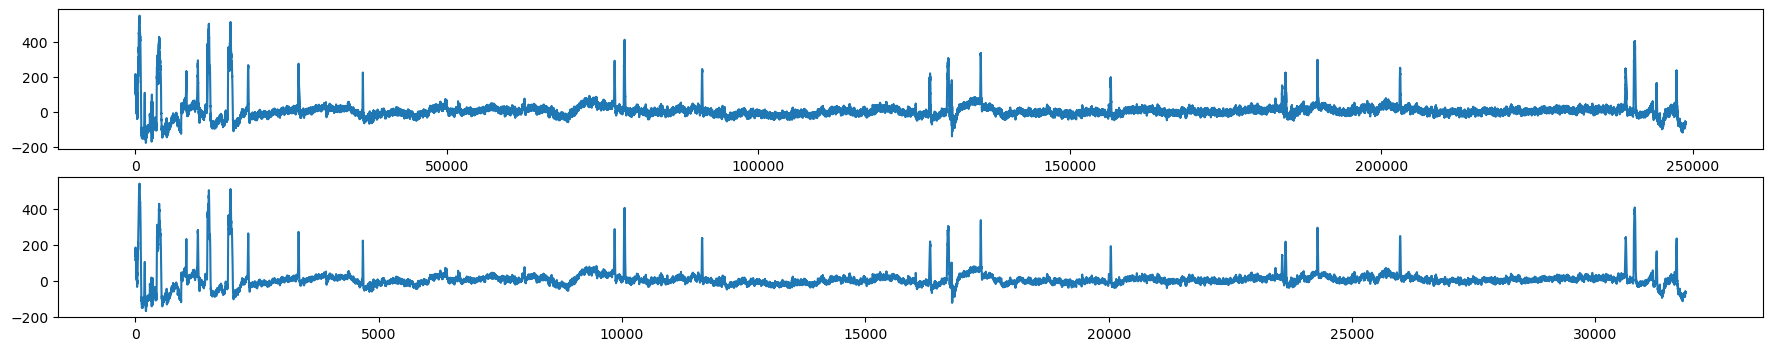

In [102]:
# downsample
plt.figure(figsize=(22,4))
plt.subplot(211)
plt.plot(eeg['eeg'][0][0])
print(len(eeg))
eeg.resample(128)
plt.subplot(212)
plt.plot(eeg['eeg'][0][0])
print(len(eeg))
plt.show()

In [103]:
# Cz re-referencing
eeg.set_eeg_reference(["CZ"])
eeg.drop_channels(['CZ'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 33 x 31852 (248.8 s), ~8.0 MB, data loaded>

Setting up band-stop filter from 49 - 51 Hz



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.50, 45.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.0s finished


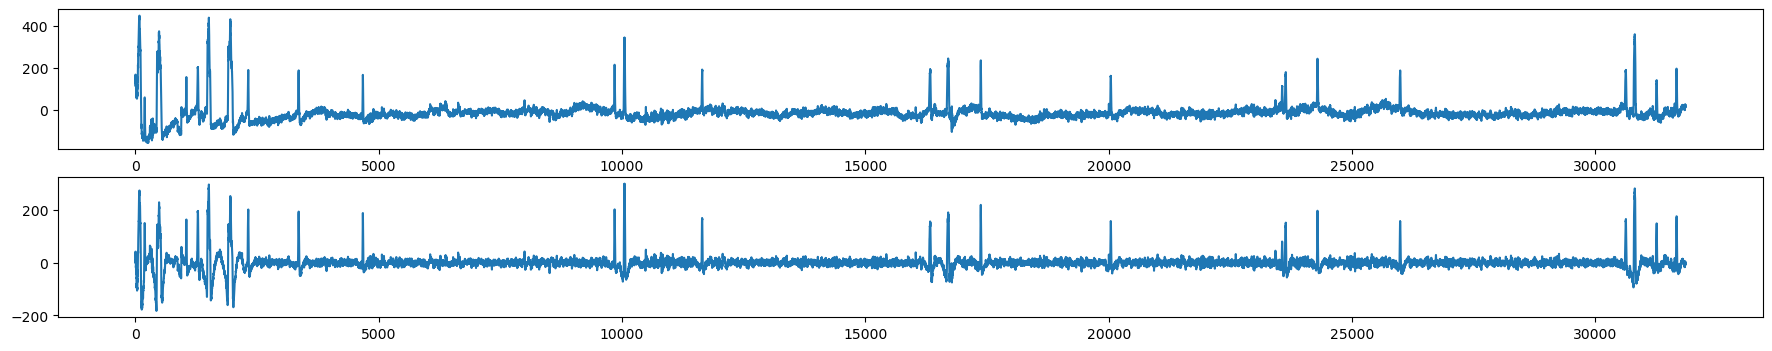

In [104]:
plt.figure(figsize=(22,4))
plt.subplot(211)
plt.plot(eeg['eeg'][0][0])
eeg.notch_filter(50)
eeg.filter(0.5,45, method='iir', iir_params=dict(order=3, ftype='butter'))
plt.subplot(212)
plt.plot(eeg['eeg'][0][0])
plt.show()

In [109]:
# ica
ica = mne.preprocessing.ICA(n_components=25, random_state=2222)
ica.fit(eeg)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 0.5s.


Method,fastica
Fit,59 iterations on raw data (31852 samples)
ICA components,25
Available PCA components,29
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=29, n_times=31852
    Range : 0 ... 31851 =      0.000 ...   248.836 secs
Ready.


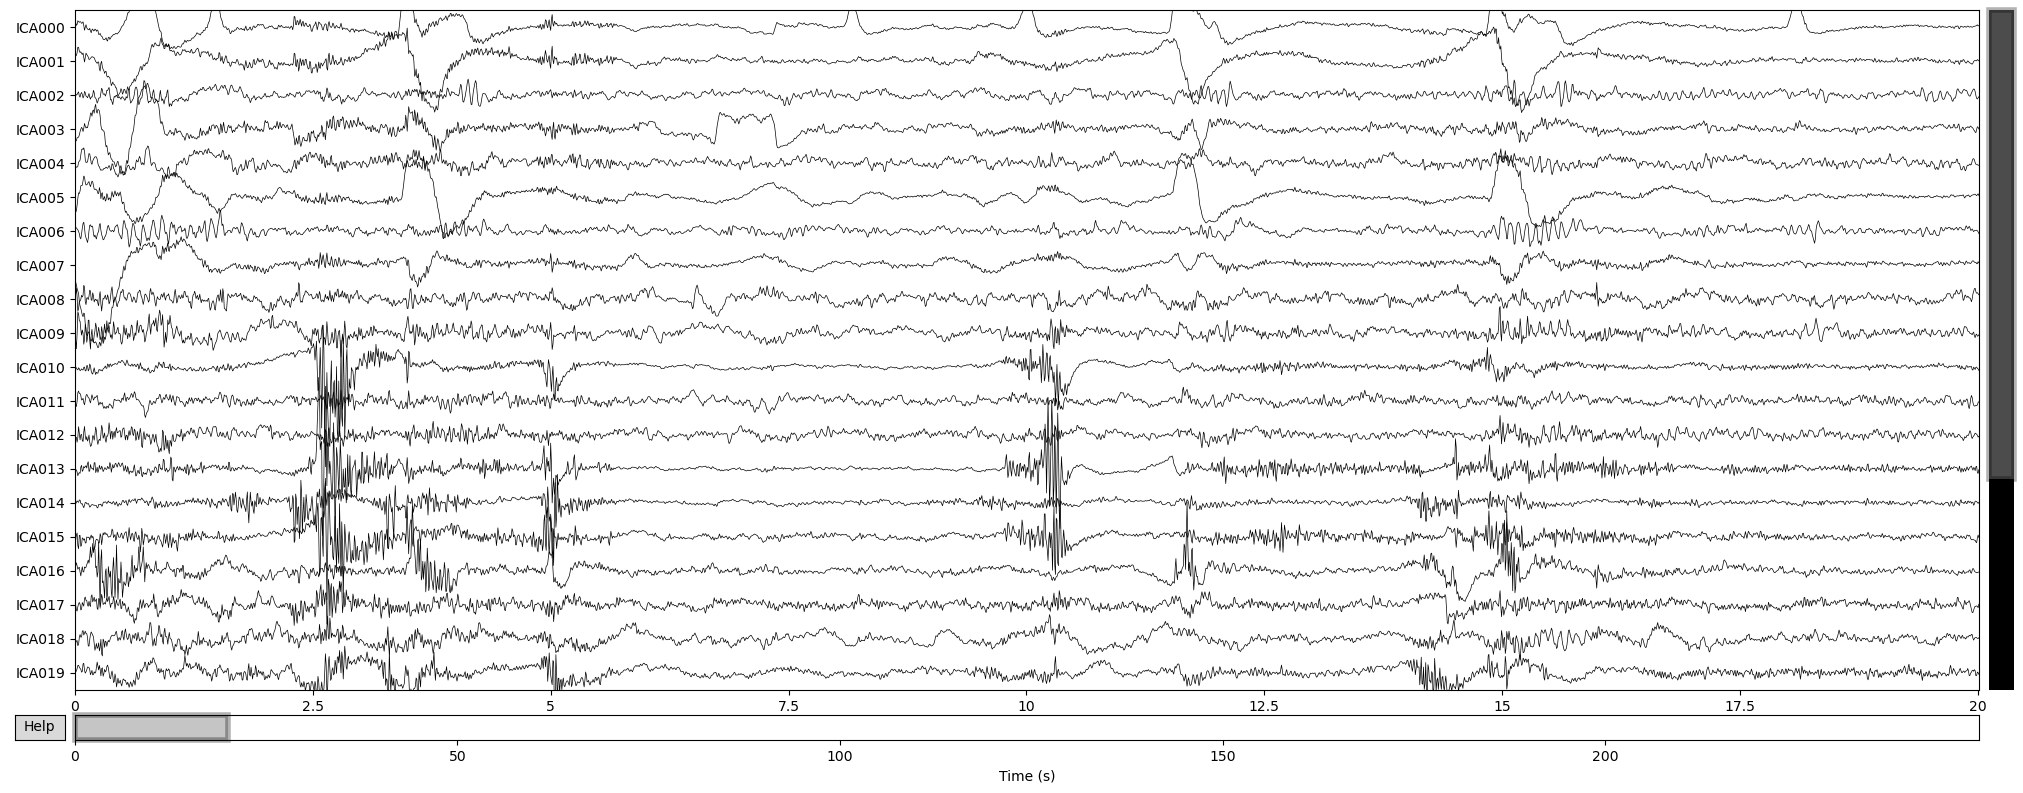

In [110]:
ica.plot_sources(eeg, show_scrollbars=True)
print()

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 29 PCA components


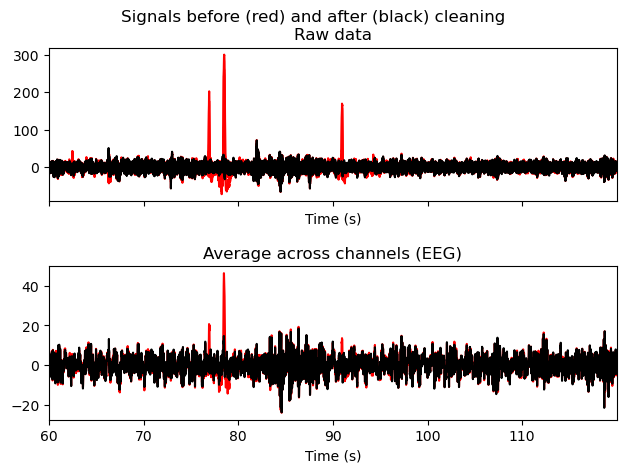

In [123]:
ica.plot_overlay(eeg, exclude=[0,1,5], start=128*60, stop=128*120, picks=['eeg'])
print()

Applying ICA to Raw instance


    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components


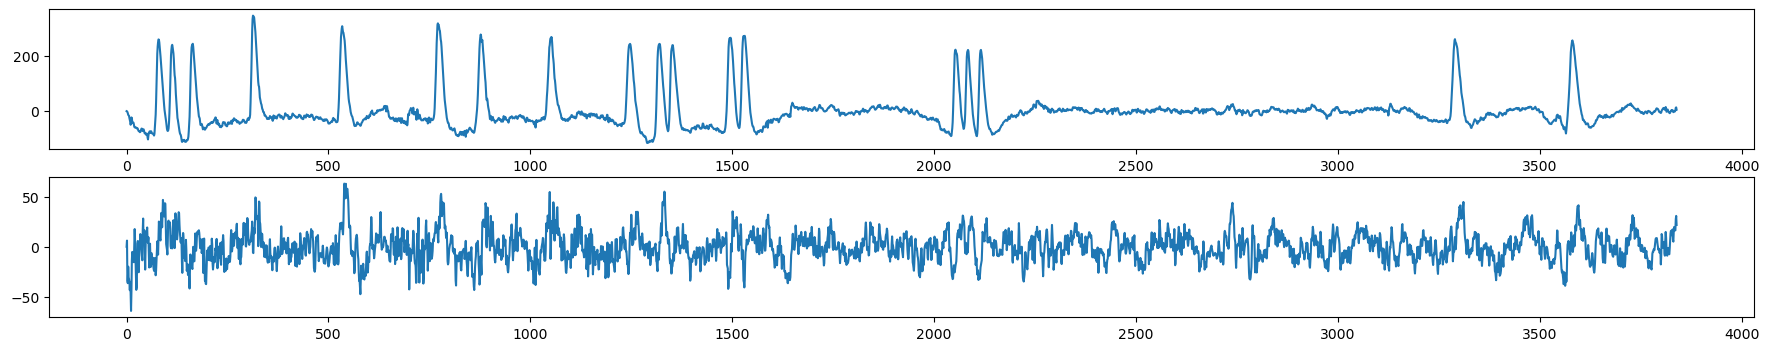

In [94]:
plt.figure(figsize=(22,4))
plt.subplot(211)
plt.plot(eeg['eeg'][0][0][128*0:128*30])

ica.exclude = [0,2]
ica.apply(eeg)

plt.subplot(212)
plt.plot(eeg['eeg'][0][0][128*0:128*30])
plt.show()


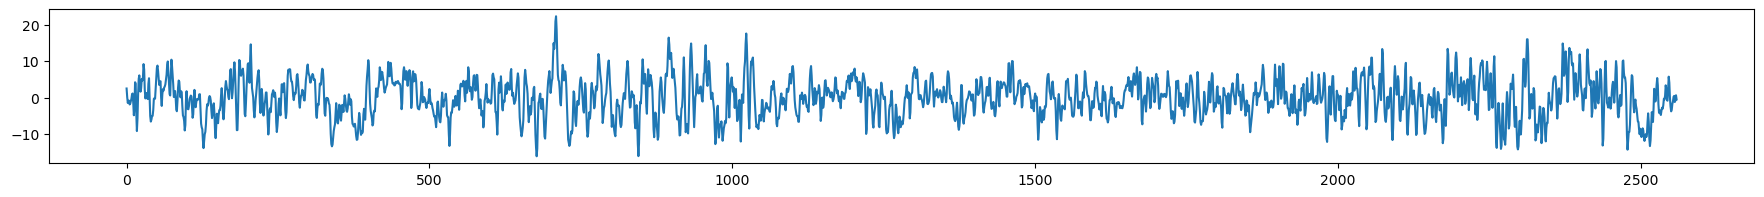

In [15]:
plt.figure(figsize=(22,2))
plt.plot(eeg['eeg'][0][10][128*10:128*30])
plt.show()

In [25]:
events[15] + 128*2

8095

In [ ]:
np.stack([eeg['eeg'][0][:,events[m*4+15]-128*30:events[m*4+15]+128*2] for m in range(4)]).shape

(4, 29, 4096)

## fnirs

In [50]:
import os 
fnirs = []
for file_name in os.listdir(f'{path}\Pre-processed Data\Pre-processed fNIRS Data\in mat')[1:]:
    temp = loadmat(f'{path}\Pre-processed Data\Pre-processed fNIRS Data\in mat\{file_name}')
    fnirs.append(temp[list(temp.keys())[-1]].swapaxes(1,2))
fnirs = np.stack([np.concatenate((fnirs[m], fnirs[m+4]), 1) for m in range(4)], 1)

In [53]:
label = np.zeros(fnirs.shape[:2])
label[:,:2] = 1
label

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [4]:
import numpy as np
path = 'D:\One_한양대학교\private object minsu\coding\data\\fNIRS-EEG_Stroop'
npz = np.load(f'{path}\stroop.npz')
print(npz['eeg'].shape)
print(npz['fnirs'][:,:,:,11:3511].shape)
print(npz['label'].shape)

(20, 4, 29, 4096)
(20, 4, 40, 3500)
(20, 4)
